In [1]:
import numpy as np
import matplotlib.pyplot as plt
import multiprocess as mp
import glob
import time
from tqdm import tqdm
import os
import sys
import pandas as pd
from eumap.misc import find_files, nan_percentile, GoogleSheet, ttprint
from eumap.raster import read_rasters, save_rasters
from eumap.mapper import SpaceOverlay
import geopandas as gpd
from pathlib import Path
from minio import Minio
import rasterio
import pyproj
from shapely.geometry import Point
import requests
import warnings



### create pseudo zero data points

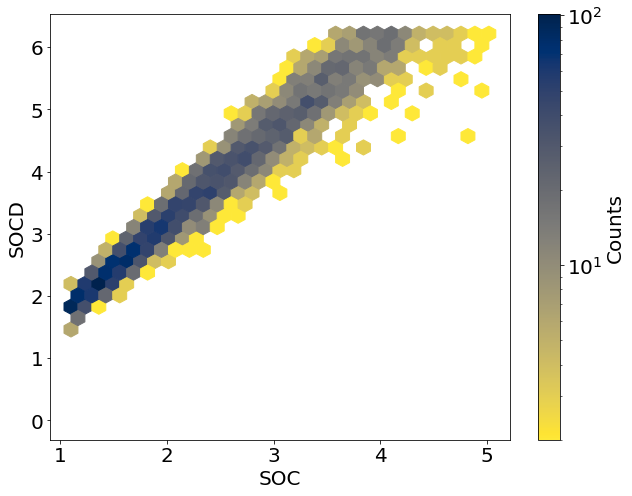

In [7]:
fig2, ax2 = plt.subplots(figsize=(9, 7))

# Second hexbin plot
hb2 = ax2.hexbin(ocd['oc'], ocd['ocd'], gridsize=30, extent = [np.log1p(2),np.log1p(150),0,np.log1p(500)], bins='log', cmap='cividis_r', mincnt=2)

# Customize plot
ax2.set_xlabel('SOC', fontsize=20)
ax2.set_ylabel('SOCD', fontsize=20)
# ax2.set_title('(D) Data availability across depth', fontsize=20)
ax2.tick_params(axis='both', which='major', labelsize=20)

# # Set the ticks to the original scale
# x_ticks = [0, 5, 10, 50, 100, 500]
# y_ticks = [0, 5, 10, 50, 100, 500]
# ax2.set_xticks(np.log1p(x_ticks))
# ax2.set_xticklabels([f'{tick:.0f}' for tick in x_ticks], fontsize=20)
# ax2.set_yticks(np.log1p(y_ticks))
# ax2.set_yticklabels([f'{tick:.0f}' for tick in y_ticks], fontsize=20)

# Adding and customizing the color bar for the second plot
color_bar2 = fig2.colorbar(hb2, ax=ax2)
color_bar2.set_label('Counts', fontsize=20)
color_bar2.ax.tick_params(labelsize=20)

# Save the second plot
plt.tight_layout()
plt.show()

In [46]:
# # create pseudo points
# new = []

# ### deeper soil
# m = df.loc[df['oc'].isna() & (df['hzn_dep']>100)]
# m['ocd'] = 0
# new.append(m)

# ### glance land cover -> ocd
# # glance = gpd.read_file('/mnt/landmark/GLANCE/bu_glance_training_dataV1.gpkg')
# # a = glance.loc[glance['Glance_Class_ID_level2'].isin([5,6])]
# # a = a.loc[a['Continent_Code'] == 4]
# # a = a.loc[a['Start_Year']>=2000]
# # a = a.loc[~a['Change']]
# # a.to_csv('/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/data_glance.pseudo.zero_eu.2000.csv',index=False)
# a = pd.read_csv('/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/data_glance.pseudo.zero_eu.2000.csv', low_memory=False)
# a['time'] = (a['Start_Year'] + a['End_Year'])/2
# a = a.rename(columns={'Lat':'lat','Lon':'lon','Glance_ID':'id','Dataset_Code':'ref'})
# a['ref'] = 'glance_datasetcode_' + a['ref'].astype(str)
# a['hzn_dep'] = 10 # assume to be top soil
# a = a[['lat','lon','id','ref','time','hzn_dep']]
# a['ocd'] = 0
# new.append(a)


# ### small SOCD from SOC
# # create pseudo zero dataset
# folder = '/home/opengeohub/xuemeng/work_xuemeng/soc'
# df = pd.read_csv(f'{folder}/data/002.2_data_whole.csv', low_memory=False)
# df = df.loc[df['oc_qa']>5]
# df = df[['id', 'lat', 'lon', 'hzn_dep', 'time', 'ref', 'nuts0','oc','ocd','oc_qa','ocd_qa','tile_id']]
# df.to_csv('/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/data_availibility_pseudo.zero.csv',index=False)

# df = pd.read_csv('/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/data_availibility_pseudo.zero.csv', low_memory=False)
# ## fit model between soc and socd
# import statsmodels.api as sm
# import statsmodels.formula.api as smf
# # soc = pd.read_csv('/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/data_availibility_soc.csv', low_memory=False)
# ocd = pd.read_csv('/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/data_availibility_socd.csv', low_memory=False)

# ocd['log_oc'] = np.log1p(ocd['oc'])
# ocd['log_ocd'] = np.log1p(ocd['ocd'])
# ocd['log_hzn_dep'] = np.log1p(ocd['hzn_dep'])

# ## gaussian GLM
# formula = 'log_ocd ~ log_oc + I(log_oc**2) + hzn_dep'  # Using actual depth here
# model = smf.glm(formula=formula, data=ocd, family=sm.families.Gaussian()).fit()
# temp = df.loc[(df['ocd_qa']<=5) | df['ocd'].isna()]
# temp = temp.loc[temp['oc']<5]

# temp['log_oc'] = np.log1p(temp['oc'])
# temp['log_ocd_pred'] = model.predict(temp)
# temp['ocd'] = np.expm1(temp['log_ocd_pred'])

# new.append(temp)
# new = pd.concat(new)
# new.to_csv('/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/data_new.points_low.socd.estimated.csv',index=False)


# geometry = [Point(xy) for xy in zip(new['lon'], new['lat'])]
# new = gpd.GeoDataFrame(new, geometry=geometry, crs="EPSG:4326")
# new = new.to_crs("EPSG:3035")


# key_file = '/mnt/primus/xuemeng_tmp_harbour/soc/data/gaia-319808-913d36b5fca4.json'
# url = 'https://docs.google.com/spreadsheets/d/1eIoPAvWM5jrhLrr25jwguAIR0YxOh3f5-CdXwpcOIz8/edit?usp=sharing'

# gsheet = GoogleSheet(key_file, url)
# covar = gsheet.covar

# def generate_overlay_path(row,year,filt=None):
#     # check if the covariates resolution is 30m, otherwise use .vrt
#     if row['spatial resolution'] != '30m':
#         if '.vrt' not in row['path']:
#             row_path = 'http://192.168.1.30:8333/ai4sh/vrt/' + row['path'].split('/')[-1] +'.vrt'
#         else:
#             row_path = row['path']
#     else:
#         row_path = row['path']
        
#     # determine if static variable
#     if row['temporal resolution'] == 'static':
#         if '{perc}' in row_path:
#             perc_list = row['perc'].split(',')
#             output_paths = [row_path.replace('{perc}', perc) for perc in perc_list]
#         else:
#             output_paths = [row_path]
        
#         return output_paths, output_paths
    
#     if row['temporal resolution'] == 'long term':
#         perc_list = row['perc'].split(',')
#         output_paths = [row_path.replace('{perc}', perc) for perc in perc_list]
#         return output_paths, output_paths
        
#     # determine if the year is ahead of the availibility of the variable
#     if year>int(row['end year']):
#         year = int(row['end year'])
#     if year<int(row['start year']):
#         year = int(row['start year'])
        
#     # determine if it's an annual variable or (bi)monthly variable
#     if '{start_m}' not in row_path:
#         output_paths = [row_path.replace('{year}',f'{int(year)}')]
#     else:
#         output_paths = []
#         start_list = row['start_m'].split(', ')
#         end_list = row['end_m'].split(', ')
#         output_paths = [row_path.replace('{year}',f'{int(year)}').replace('{start_m}',start_list[i]).replace('{end_m}',end_list[i]) for i in range(len(end_list))]
    
#     if '{perc}' in row_path:
#         perc_list = row['perc'].split(',')
#         output_paths = [p.replace('{perc}', perc) for p in output_paths for perc in perc_list]
        
#     if (row['leap year'] == '1') & (year%4==0):
#         output_paths = [p.replace('0228', '0229') if '0228' in p else p for p in output_paths]
    
#     return output_paths, [i.replace(str(int(year)),'{year}') for i in output_paths]
    
# def check_path(url):
#     try:
#         response = requests.head(url, allow_redirects=True, timeout=5)
#         # Check if the status code is not 200 (OK). You might want to specifically check for 404 or other error codes.
#         if response.status_code == 404:
#             print(f"{url} returned HTTP 404 Not Found")
#             return url
#         elif response.status_code != 200: # URL is fine (HTTP 200)
#             print(f"{url} returned HTTP {response.status_code}")
#             return url
#         return None  # also could be adapted to handle redirections (HTTP 3xx) separately if needed.
#     except requests.RequestException as e:
#         print(f"Failed to retrieve {url}: {str(e)}")
#         return url

    
# import warnings
# warnings.filterwarnings("ignore")

# for year in np.arange(2000,2024):
#     temp = new.loc[new['time']==year]
#     if len(temp)==0:
#         print(f'no data for year {year}, skip!')
#     else:
#         print(f'overlaying for year {year}, size {len(temp)}')
#     dym_path = []
#     namel = []
#     for index,row in covar.iterrows():
#         paths, names = generate_overlay_path(row, year)
#         dym_path.extend(paths)
#         namel.extend(names)
        
#     namel = [ii.split('/')[-1][0:-4] for ii in namel]
#     name_map = dict(zip(dym_path,namel))
    
#     dym_path = [ip.replace('.1.','.49.') for ip in dym_path]
#     dym_path = [Path(ip) for ip in dym_path]
#     print(f'overlaying covariates number: {len(dym_path)}')
        
#     temp = SpaceOverlay(
#         points=temp, 
#         fn_layers=dym_path, verbose=True
#     ).run()
    
#     temp = temp.rename(columns = name_map)
#     temp = temp.drop(columns=['overlay_id', 'geometry'])
#     temp.to_csv(f'/home/opengeohub/xuemeng/work_xuemeng/soc/temp_overlap/dft_{int(year)}_new.points.csv',index=False)

In [105]:
# newf = find_files('/home/opengeohub/xuemeng/work_xuemeng/soc/temp_overlap/','*new.points*')
# newf = [str(i) for i in newf]

merge = []
for year in np.arange(2000,2022):
    dym_path = []
    namel = []
    for index,row in covar.iterrows():
        paths, names = generate_overlay_path(row, year)
        dym_path.extend(paths)
        namel.extend(names)
        
    dym_path = [ii.split('/')[-1][0:-4] for ii in dym_path]
    namel = [ii.split('/')[-1][0:-4] for ii in namel]
    name_map = dict(zip(dym_path,namel))
    
    ff = f'/home/opengeohub/xuemeng/work_xuemeng/soc/temp_overlap/dft_{int(year)}_new.points.csv'
    temp = pd.read_csv(ff, low_memory=False)
        
    temp = temp.rename(columns = name_map)
    merge.append(temp)
    
merge = pd.concat(merge)
crop = 'cropland.extent_glad.interpolate_p_30m_s_{year}0101_{year}1231_eu_epsg.3035_v20240604'
merge.loc[merge[crop].isna(),crop] = 0
merge.loc[merge[crop]>0,crop] = 100

In [106]:
from eumap.parallel import TilingProcessing
from pathlib import Path
import rasterio
from shapely.geometry import box
import numpy as np
import pandas as pd
import geopandas as gpd

dff = merge
from shapely.geometry import Point
tiles = gpd.read_file(f'/home/opengeohub/xuemeng/work_xuemeng/soc/data/000_tiles.correct_epsg.3035.gpkg')

# dff = pd.read_csv(f'{folder}/data/001_covar_overlayed.csv',low_memory=False)
gdf = gpd.GeoDataFrame(dff, geometry=gpd.points_from_xy(dff.lon, dff.lat))
gdf.crs = 'EPSG:4326'
gdf = gdf.to_crs(tiles.crs)

# join spatial
joined_gdf = gpd.sjoin(gdf, tiles, how="left", op='within')
joined_gdf = joined_gdf.drop(columns=['geometry', 'index_right','tile_id'])
joined_gdf = joined_gdf.rename(columns={'id_right':'tile_id','id_left':'id'})
joined_gdf.to_csv(f'/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/data_new.points_overlayed.csv',index=False)

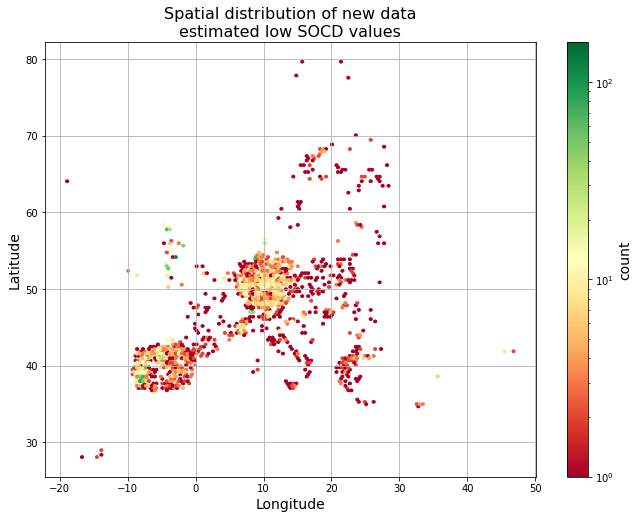

In [30]:
data = new
import matplotlib.colors as mcolors
fig, ax = plt.subplots(figsize=(11, 8))
hexbin = ax.hexbin(data['lon'], data['lat'], gridsize=150, cmap='RdYlGn', mincnt=1, norm=mcolors.LogNorm())
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)
ax.set_title(f'Spatial distribution of new data\nestimated low SOCD values', fontsize=16)

# if latbox is not None:
#     ax.set_ylim(latbox)
# if lonbox is not None:
#     ax.set_xlim(lonbox)
colorbar = plt.colorbar(hexbin)
colorbar.set_label(f'count', fontsize=14)

plt.grid(True)
plt.show()

### examine R2

In [28]:
## fit model between soc and socd
import statsmodels.api as sm
import statsmodels.formula.api as smf
# soc = pd.read_csv('/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/data_availibility_soc.csv', low_memory=False)
ocd = pd.read_csv('/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/data_availibility_socd.csv', low_memory=False)

ocd['log_oc'] = np.log1p(ocd['oc'])
ocd['log_ocd'] = np.log1p(ocd['ocd'])
ocd['log_hzn_dep'] = np.log1p(ocd['hzn_dep'])


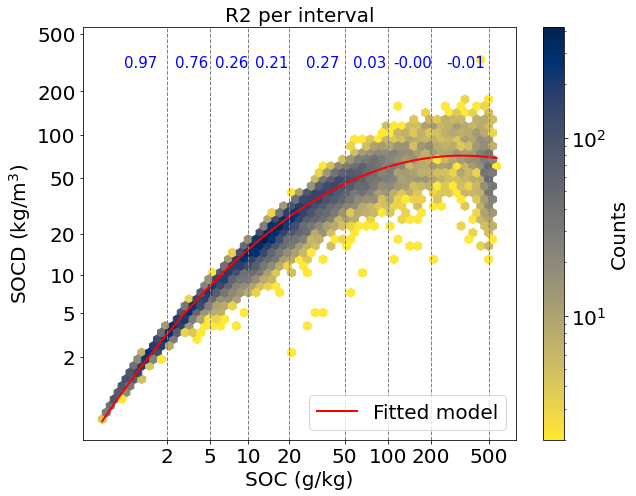

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score

# Assuming 'ocd' DataFrame and 'model' are defined properly
# Fit data preparation
x_fit = np.linspace(ocd['log_oc'].min(), ocd['log_oc'].max(), 1000)  # More points for a smoother line
predict_df = pd.DataFrame({
    'log_oc': x_fit,
    'I(log_oc ** 2)': x_fit**2,  # Ensure the quadratic term is correctly specified
    'hzn_dep': np.full_like(x_fit, 90)  # Fixed depth of 90 cm for all predictions
})
y_fit = model.predict(predict_df)

# Define the SOC ranges
# soc_ranges = [(0, 5), (5, 10), (10, 20), (20, 50), (50, 100), (100, 200), (200, 500)]
soc_ranges = [(0, 2), (2, 5), (5, 10), (10, 20), (20, 50), (50, 100), (100, 200), (200, 500)]

r2_values = []

# Calculate R2 for each interval
for soc_min, soc_max in soc_ranges:
    # Filter data within the range
    mask = (ocd['log_oc'] >= np.log1p(soc_min)) & (ocd['log_oc'] < np.log1p(soc_max))
    subset = ocd[mask]
    
    if not subset.empty:
        # Create prediction data for this subset
        predict_df_subset = pd.DataFrame({
            'log_oc': subset['log_oc'],
            'I(log_oc ** 2)': subset['log_oc']**2,
            'hzn_dep': np.full_like(subset['log_oc'], 90)
        })
        y_pred_subset = model.predict(predict_df_subset)
        
        # Calculate R2
        r2 = r2_score(subset['log_ocd'], y_pred_subset)
        r2_values.append((soc_min, soc_max, r2))
    else:
        r2_values.append((soc_min, soc_max, None))

# Plot the data using the log-transformed values
fig, ax = plt.subplots(figsize=(9, 7))  # Adjusted for a single plot

# Hexbin plot
hb = ax.hexbin(ocd['log_oc'], ocd['log_ocd'], gridsize=50, bins='log', cmap='cividis_r', mincnt=2)

# Plot the fitted line
ax.plot(x_fit, y_fit, color='red', linewidth=2, label='Fitted model')

# Customize plot
ax.set_xlabel('SOC (g/kg)', fontsize=20)
ax.set_ylabel('SOCD (kg/m$^3$)', fontsize=20)
ax.set_title('R2 per interval', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend(fontsize=20, loc='lower right')

# Set the ticks to the original scale
x_ticks = [2, 5, 10, 20, 50, 100, 200, 500]
y_ticks = [2, 5, 10, 20, 50, 100, 200, 500]
ax.set_xticks(np.log1p(x_ticks))
ax.set_xticklabels([f'{tick:.0f}' for tick in x_ticks], fontsize=20)
ax.set_yticks(np.log1p(y_ticks))
ax.set_yticklabels([f'{tick:.0f}' for tick in y_ticks], fontsize=20)

# Adding and customizing the color bar
color_bar = fig.colorbar(hb, ax=ax)
color_bar.set_label('Counts', fontsize=20)
color_bar.ax.tick_params(labelsize=20)

# Annotate R2 values on the plot
for soc_min, soc_max, r2 in r2_values:
    if r2 is not None:
        x_position = np.log1p((soc_min + soc_max) / 2)  # Midpoint of the interval
        ax.text(x_position, ax.get_ylim()[1] * 0.9, f'{r2:.2f}', fontsize=15, ha='center', color='blue')

# Add dotted lines for each interval boundary
intervals = [2, 5, 10, 20, 50, 100, 200, 500]
for boundary in intervals:
    ax.axvline(x=np.log1p(boundary), color='gray', linestyle='--', linewidth=1)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


In [30]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np

# Fit the model
formula = 'log_ocd ~ log_oc + I(log_oc**2) + hzn_dep'
model = smf.glm(formula=formula, data=ocd, family=sm.families.Gaussian()).fit()

# Print the summary of the model to get all statistics
print(model.summary())

# Access the specific parameters
params = model.params
print('Coefficients:')
print(params)

# Extract coefficients individually
beta_0 = params['Intercept']
beta_1 = params['log_oc']
beta_2 = params['I(log_oc ** 2)']
beta_3 = params['hzn_dep']

print(f"Intercept (beta_0): {beta_0}")
print(f"Coefficient for log_oc (beta_1): {beta_1}")
print(f"Coefficient for log_oc^2 (beta_2): {beta_2}")
print(f"Coefficient for hzn_dep (beta_3): {beta_3}")

                 Generalized Linear Model Regression Results                  
Dep. Variable:                log_ocd   No. Observations:                22428
Model:                            GLM   Df Residuals:                    22424
Model Family:                Gaussian   Df Model:                            3
Link Function:               identity   Scale:                        0.051206
Method:                          IRLS   Log-Likelihood:                 1504.9
Date:                Fri, 13 Sep 2024   Deviance:                       1148.2
Time:                        11:19:19   Pearson chi2:                 1.15e+03
No. Iterations:                     3   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.1472      0.011    -13.

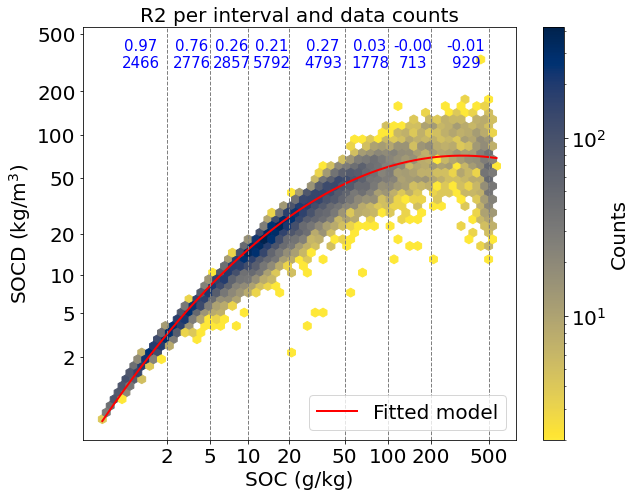

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score

# Assuming 'ocd' DataFrame and 'model' are defined properly
# Fit data preparation
x_fit = np.linspace(ocd['log_oc'].min(), ocd['log_oc'].max(), 1000)  # More points for a smoother line
predict_df = pd.DataFrame({
    'log_oc': x_fit,
    'I(log_oc ** 2)': x_fit**2,  # Ensure the quadratic term is correctly specified
    'hzn_dep': np.full_like(x_fit, 90)  # Fixed depth of 90 cm for all predictions
})
y_fit = model.predict(predict_df)

# Define the SOC ranges
soc_ranges = [(0, 2), (2, 5), (5, 10), (10, 20), (20, 50), (50, 100), (100, 200), (200, 500)]
r2_values = []
counts = []

# Calculate R2 and data counts for each interval
for soc_min, soc_max in soc_ranges:
    # Filter data within the range
    mask = (ocd['log_oc'] >= np.log1p(soc_min)) & (ocd['log_oc'] < np.log1p(soc_max))
    subset = ocd[mask]
    
    # Count the data points in this range
    count = len(subset)
    counts.append((soc_min, soc_max, count))
    
    if not subset.empty:
        # Create prediction data for this subset
        predict_df_subset = pd.DataFrame({
            'log_oc': subset['log_oc'],
            'I(log_oc ** 2)': subset['log_oc']**2,
            'hzn_dep': np.full_like(subset['log_oc'], 90)
        })
        y_pred_subset = model.predict(predict_df_subset)
        
        # Calculate R2
        r2 = r2_score(subset['log_ocd'], y_pred_subset)
        r2_values.append((soc_min, soc_max, r2))
    else:
        r2_values.append((soc_min, soc_max, None))

# Plot the data using the log-transformed values
fig, ax = plt.subplots(figsize=(9, 7))  # Adjusted for a single plot

# Hexbin plot
hb = ax.hexbin(ocd['log_oc'], ocd['log_ocd'], gridsize=50, bins='log', cmap='cividis_r', mincnt=2)

# Plot the fitted line
ax.plot(x_fit, y_fit, color='red', linewidth=2, label='Fitted model')

# Customize plot
ax.set_xlabel('SOC (g/kg)', fontsize=20)
ax.set_ylabel('SOCD (kg/m$^3$)', fontsize=20)
ax.set_title('R2 per interval (up) and data counts (low)', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend(fontsize=20, loc='lower right')

# Set the ticks to the original scale
x_ticks = [2, 5, 10, 20, 50, 100, 200, 500]
y_ticks = [2, 5, 10, 20, 50, 100, 200, 500]
ax.set_xticks(np.log1p(x_ticks))
ax.set_xticklabels([f'{tick:.0f}' for tick in x_ticks], fontsize=20)
ax.set_yticks(np.log1p(y_ticks))
ax.set_yticklabels([f'{tick:.0f}' for tick in y_ticks], fontsize=20)

# Adding and customizing the color bar
color_bar = fig.colorbar(hb, ax=ax)
color_bar.set_label('Counts', fontsize=20)
color_bar.ax.tick_params(labelsize=20)

# Annotate R2 values and counts on the plot
for (soc_min, soc_max, r2), (_, _, count) in zip(r2_values, counts):
    if r2 is not None:
        x_position = np.log1p((soc_min + soc_max) / 2)  # Midpoint of the interval
        ax.text(x_position, ax.get_ylim()[1] * 0.9, f'{r2:.2f}\n{count}', fontsize=15, ha='center', color='blue')

# Add dotted lines for each interval boundary
intervals = [2, 5, 10, 20, 50, 100, 200, 500]
for boundary in intervals:
    ax.axvline(x=np.log1p(boundary), color='gray', linestyle='--', linewidth=1)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


### generate plot

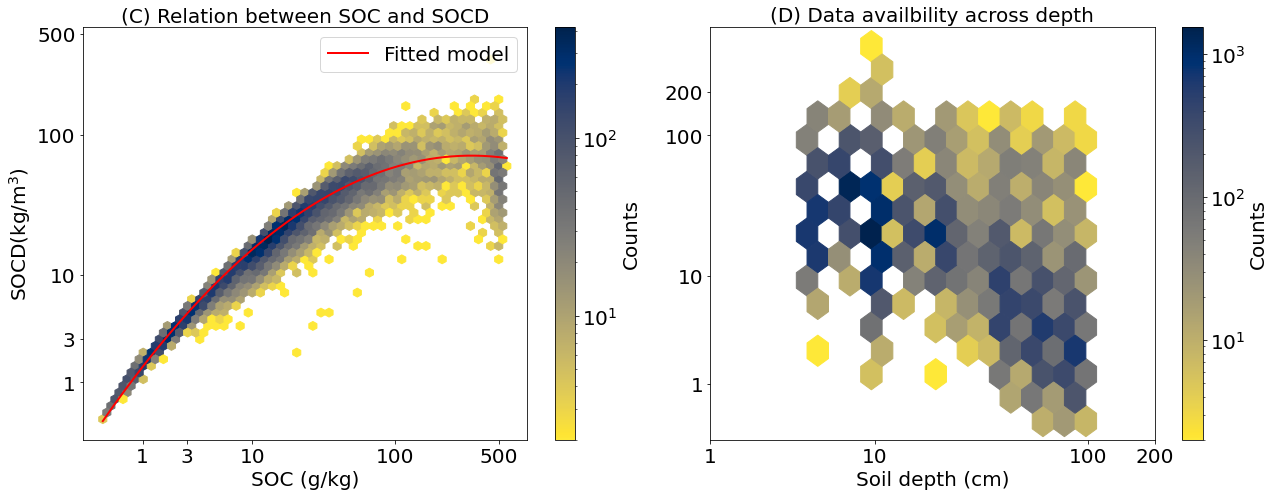

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd



x_fit = np.linspace(ocd['log_oc'].min(), ocd['log_oc'].max(), 1000)  # More points for a smoother line
predict_df = pd.DataFrame({
    'log_oc': x_fit,
    'I(log_oc ** 2)': x_fit**2,  # Ensure the quadratic term is correctly specified
    'hzn_dep': np.full_like(x_fit, 90)  # Fixed depth of 10 cm for all predictions
})
y_fit = model.predict(predict_df)

# # polynominal
# coefficients = np.polyfit(ocd['log_oc'], ocd['log_ocd'], 2)
# poly = np.poly1d(coefficients)
# x_fit = np.linspace(ocd['log_oc'].min(), ocd['log_oc'].max(), 1000)
# y_fit = poly(x_fit)


# Plot the data using the log-transformed values
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))

# First subplot
hb1 = axes[0].hexbin(ocd['log_oc'], ocd['log_ocd'], gridsize=50, bins='log', cmap='cividis_r', mincnt=2)

# Plot the fitted line
axes[0].plot(x_fit, y_fit, color='red', linewidth=2, label='Fitted model')

# Customize plot
axes[0].set_xlabel('SOC (g/kg)', fontsize=20)
axes[0].set_ylabel('SOCD(kg/m$^3$)', fontsize=20)
axes[0].set_title('(C) Relation between SOC and SOCD', fontsize=20)
axes[0].tick_params(axis='both', which='major', labelsize=20)
axes[0].legend(fontsize=20)

# Set the ticks to the original scale
x_ticks = [1, 3, 10, 100, 500]
y_ticks = [1, 3, 10, 100, 500]
axes[0].set_xticks(np.log1p(x_ticks))
axes[0].set_xticklabels([f'{tick:.0f}' for tick in x_ticks], fontsize=20)
axes[0].set_yticks(np.log1p(y_ticks))
axes[0].set_yticklabels([f'{tick:.0f}' for tick in y_ticks], fontsize=20)

# Adding and customizing the color bar for the first plot
color_bar1 = fig.colorbar(hb1, ax=axes[0])
color_bar1.set_label('Counts', fontsize=20)
color_bar1.ax.tick_params(labelsize=20)

# Second subplot
hb2 = axes[1].hexbin(ocd['log_hzn_dep'], ocd['log_ocd'], gridsize=15, bins='log', cmap='cividis_r', mincnt=2)

# Customize plot
axes[1].set_xlabel('Soil depth (cm)', fontsize=20)
# axes[1].set_ylabel('SOCD(kg/m$^3$)', fontsize=20)
axes[1].set_title('(D) Data availbility across depth', fontsize=20)
axes[1].tick_params(axis='both', which='major', labelsize=20)

# Set the ticks to the original scale
x_ticks = [1, 10, 100, 200]
y_ticks = [1, 10, 100, 200]
axes[1].set_xticks(np.log1p(x_ticks))
axes[1].set_xticklabels([f'{tick:.0f}' for tick in x_ticks], fontsize=20)
axes[1].set_yticks(np.log1p(y_ticks))
axes[1].set_yticklabels([f'{tick:.0f}' for tick in y_ticks], fontsize=20)

# Adding and customizing the color bar for the second plot
color_bar2 = fig.colorbar(hb2, ax=axes[1])
color_bar2.set_label('Counts', fontsize=20)
color_bar2.ax.tick_params(labelsize=20)

# Adjust layout
plt.tight_layout()
# plt.savefig("/home/opengeohub/xuemeng/work_xuemeng/soc/visualizaiton/plot_data.availbility.svg", format='svg')

# Show the plot
plt.show()




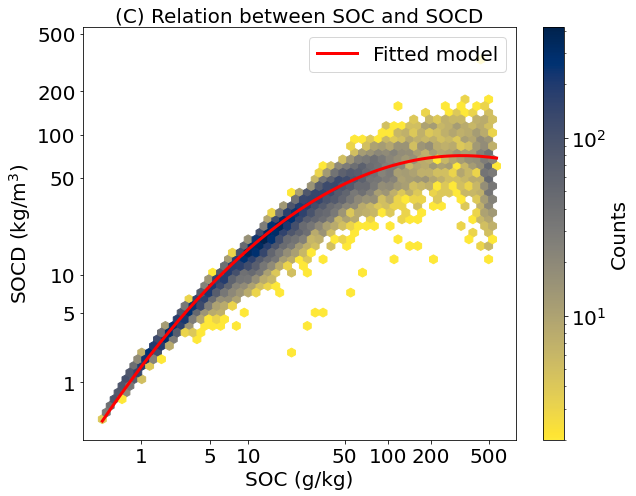

In [47]:
# Plot the first figure
fig1, ax1 = plt.subplots(figsize=(9, 7))

# First hexbin plot
hb1 = ax1.hexbin(ocd['log_oc'], ocd['log_ocd'], gridsize=50, bins='log', cmap='cividis_r', mincnt=2)

# Plot the fitted line
ax1.plot(x_fit, y_fit, color='red', linewidth=3, label='Fitted model')

# Customize plot
ax1.set_xlabel('SOC (g/kg)', fontsize=20)
ax1.set_ylabel('SOCD (kg/m$^3$)', fontsize=20)
ax1.set_title('(C) Relation between SOC and SOCD', fontsize=20)
ax1.tick_params(axis='both', which='major', labelsize=20)
ax1.legend(fontsize=20)

# Set the ticks to the original scale
x_ticks = [1, 5, 10, 50, 100, 200, 500]
y_ticks = [1, 5, 10, 50, 100, 200, 500]
ax1.set_xticks(np.log1p(x_ticks))
ax1.set_xticklabels([f'{tick:.0f}' for tick in x_ticks], fontsize=20)
ax1.set_yticks(np.log1p(y_ticks))
ax1.set_yticklabels([f'{tick:.0f}' for tick in y_ticks], fontsize=20)


# Adding and customizing the color bar for the first plot
color_bar1 = fig1.colorbar(hb1, ax=ax1)
color_bar1.set_label('Counts', fontsize=20)
color_bar1.ax.tick_params(labelsize=20)

# Save the first plot
plt.tight_layout()
plt.savefig("/home/opengeohub/xuemeng/work_xuemeng/soc/visualizaiton/plot_data.availbility_C.svg", format='svg')

# Show the first plot
plt.show()




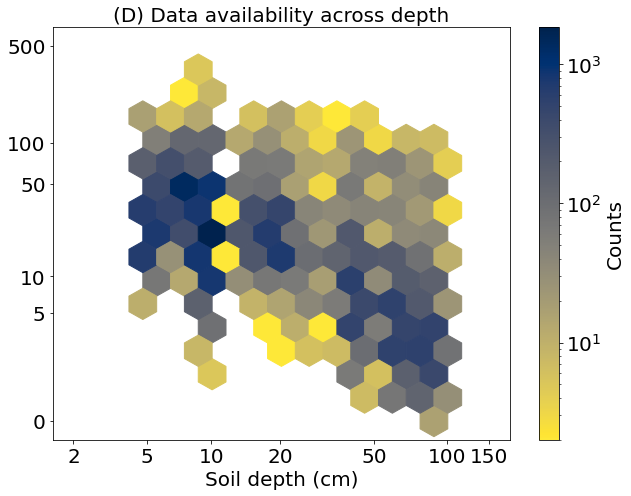

In [62]:
# Plot the second figure
fig2, ax2 = plt.subplots(figsize=(9, 7))

# Second hexbin plot
hb2 = ax2.hexbin(ocd['log_hzn_dep'], ocd['log_ocd'], gridsize=15, extent = [np.log1p(2),np.log1p(150),0,np.log1p(500)], bins='log', cmap='cividis_r', mincnt=2)

# Customize plot
ax2.set_xlabel('Soil depth (cm)', fontsize=20)
ax2.set_title('(D) Data availability across depth', fontsize=20)
ax2.tick_params(axis='both', which='major', labelsize=20)

# Set the ticks to the original scale
x_ticks = [2, 5, 10, 20, 50, 100, 150]
y_ticks = [0, 5, 10, 50, 100, 500]
ax2.set_xticks(np.log1p(x_ticks))
ax2.set_xticklabels([f'{tick:.0f}' for tick in x_ticks], fontsize=20)
ax2.set_yticks(np.log1p(y_ticks))
ax2.set_yticklabels([f'{tick:.0f}' for tick in y_ticks], fontsize=20)

# Adding and customizing the color bar for the second plot
color_bar2 = fig2.colorbar(hb2, ax=ax2)
color_bar2.set_label('Counts', fontsize=20)
color_bar2.ax.tick_params(labelsize=20)

# Save the second plot
plt.tight_layout()
plt.savefig("/home/opengeohub/xuemeng/work_xuemeng/soc/visualizaiton/plot_data.availbility_D.svg", format='svg')

# Show the second plot
plt.show()


In [25]:
for iref in ocd['ref'].unique():
    temp = ocd.loc[ocd['ref'] == iref]
    print(iref)
    print(temp['time'].unique())
    print()

ukceh
[2007.]

SoDaH
[2008.]

germany.thuenen
[2011. 2012. 2013. 2014. 2015. 2016. 2017. 2018.]

croatia.multione
[2015. 2016.]

LUCAS
[2018.]



In [5]:
import matplotlib.pyplot as plt

# Assuming 'weird' is your DataFrame that contains 'oc' and 'bulk_density' columns

plt.figure(figsize=(10, 8))

# Create a hexbin plot
hb = plt.hexbin(weird['oc'], weird['bulk_density'], gridsize=50, cmap='viridis',mincnt=1)

# Add color bar
color_bar = plt.colorbar(hb)
color_bar.set_label('Counts', fontsize=15)

# Customize plot
plt.xlabel('OC (g/kg)', fontsize=20)
plt.ylabel('Bulk Density (g/cm³)', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('OC vs BD', fontsize=20)

# Show the plot
plt.tight_layout()
plt.show()



NameError: name 'weird' is not defined

<Figure size 720x576 with 0 Axes>

In [ ]:
weird.loc[weird['bulk_density']<0.15]['ref'].unique()

<Axes: >

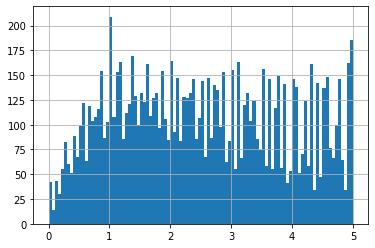

In [22]:
soc['oc'].hist(bins=100,range=[0,5])

In [19]:
idl = ocd['id'].values.tolist()

In [ ]:
# # create soc dataset
# # folder = '/home/opengeohub/xuemeng/work_xuemeng/soc'
# # df = pd.read_csv(f'{folder}/data/002.2_data_whole.csv', low_memory=False)

# # df = df.loc[df['oc_qa']>5]
# # df = df.loc[df['oc'].notna()]

# # df = df[['id', 'lat', 'lon', 'hzn_dep', 'time', 'ref', 'nuts0','oc','tile_id']]

# # df.to_csv('/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/data_availibility_soc.csv',index=False)

In [ ]:
# # # plot in original scale
# import matplotlib.pyplot as plt
# import numpy as np

# # Assuming 'ocd' is your DataFrame and it has 'oc', 'ocd', and 'hzn_dep' columns
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))

# # First subplot
# hb1 = axes[0].hexbin(ocd['oc'], ocd['ocd'], gridsize=50, bins='log', cmap='cividis_r', mincnt=2)

# # Polynomial fitting (2nd degree)
# coefficients = np.polyfit(ocd['oc'], ocd['ocd'], 2)
# poly = np.poly1d(coefficients)
# x_fit = np.linspace(ocd['oc'].min(), ocd['oc'].max(), 1000)
# y_fit = poly(x_fit)

# # Plot the fitted line
# axes[0].plot(x_fit, y_fit, color='red', linewidth=2, label='Polynomial Fit')

# # Customize plot
# axes[0].set_xlabel('SOC (g/kg)', fontsize=20)
# axes[0].set_ylabel('SOCD(kg/m$^3$)', fontsize=20)
# axes[0].set_title('(C)', fontsize=20)
# axes[0].tick_params(axis='both', which='major', labelsize=20)
# axes[0].legend(fontsize=20)

# # Adding and customizing the color bar for the first plot
# color_bar1 = fig.colorbar(hb1, ax=axes[0])
# color_bar1.set_label('Counts', fontsize=20)
# color_bar1.ax.tick_params(labelsize=20)

# # Second subplot
# hb2 = axes[1].hexbin(ocd['ocd'], ocd['hzn_dep'], gridsize=30, bins='log', cmap='cividis_r', mincnt=2)

# # Customize plot
# axes[1].set_ylabel('Soil depth (cm)', fontsize=20)
# axes[1].set_xlabel('SOCD(kg/m$^3$)', fontsize=20)
# axes[1].set_title('(D)', fontsize=20)
# axes[1].tick_params(axis='both', which='major', labelsize=20)

# # Adding and customizing the color bar for the second plot
# color_bar2 = fig.colorbar(hb2, ax=axes[1])
# color_bar2.set_label('Counts', fontsize=20)
# color_bar2.ax.tick_params(labelsize=20)

# # Adjust layout
# plt.tight_layout()
# # plt.savefig("/home/opengeohub/xuemeng/work_xuemeng/soc/visualizaiton/plot_data.availbility.svg", format='svg')

# # Show the plot
# plt.show()
